In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr
import numpy as np
from scipy.stats import binned_statistic_2d
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors
from src.plotting import *
from src.regions import *
from src.pf_stats import *
from src.daily import *

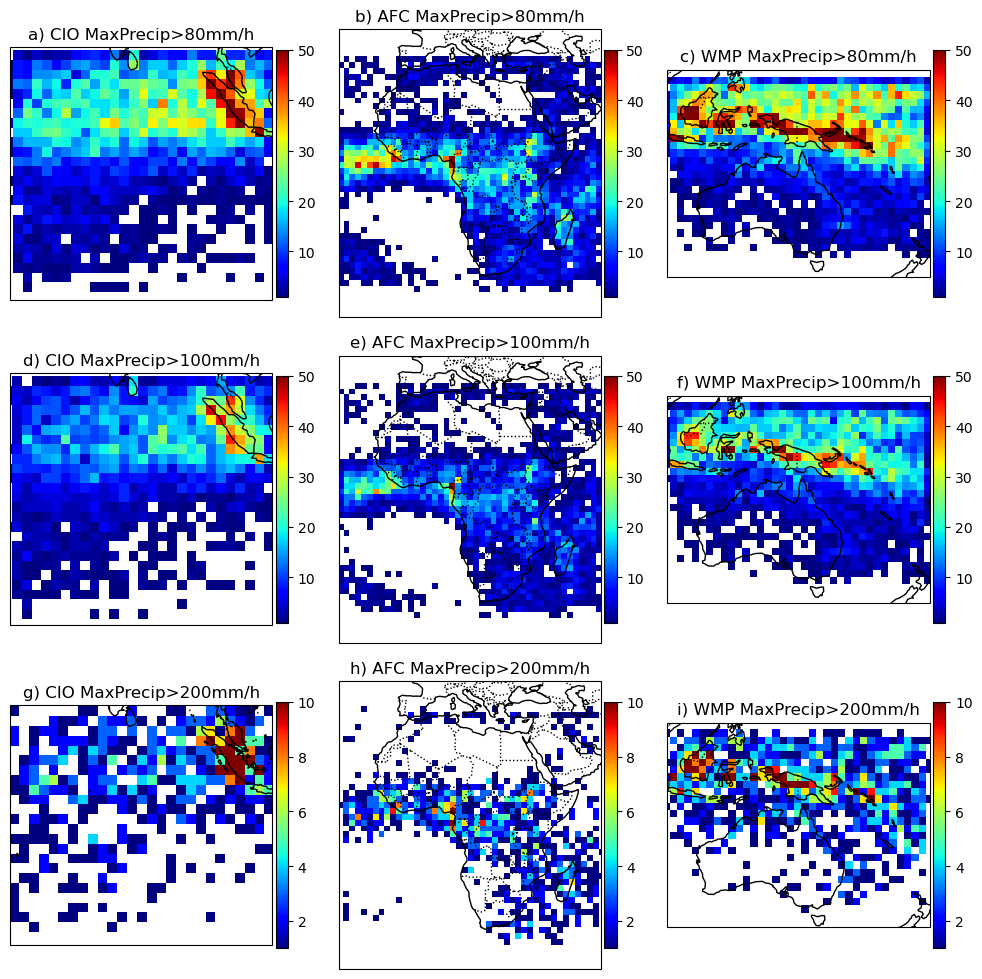

In [4]:
fig, axs = plt.subplots(figsize=(10, 10), ncols=3, nrows=3, subplot_kw={'projection': ccrs.PlateCarree()})
regions = [cio_region(), afc_region(), wmp_region()]
threshs = [80,100,200]

for coli, region in enumerate(regions):
    for rowi, thresh in enumerate(threshs):
        ax = axs[rowi, coli]
        pf_stats = load_pf_stats(region)

        lat_bins = np.arange(-60, 60, 2)
        lon_bins = np.arange(-180, 180, 2)
        

        ## Plot the number of extreme PFs
        max_pr = pf_stats.max_precip
        max_pr_pfs = pf_stats[max_pr>=thresh]
        lat, lon = max_pr_pfs.mean_latitude, max_pr_pfs.mean_longitude
        binned_counts = binned_statistic_2d(lat, lon, None, statistic='count', bins=[lat_bins, lon_bins]).statistic
        lat_midpoints = (lat_bins[1:] + lat_bins[:-1])/2
        lon_midpoints = (lon_bins[1:] + lon_bins[:-1])/2
        lon_mesh, lat_mesh = np.meshgrid(lon_midpoints, lat_midpoints)
        cmap = plt.cm.jet.copy()
        cmap.set_under('white')
        if rowi==0:
            norm = colors.Normalize(vmin=1, vmax=50)
        if rowi==2:
            norm = colors.Normalize(vmin=1, vmax=10)

        c = ax.pcolormesh(lon_mesh, lat_mesh, binned_counts, cmap=cmap, norm=norm)
        cb = fig.colorbar(c, orientation='vertical', pad=0.01, shrink=0.8)
        cb.ax.set_label('Counts')

       

        # Add map features
        ax.coastlines()
        ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()])

        ax.add_feature(cfeature.BORDERS, linestyle=':')

        plot_label = chr(ord('a') + np.ravel_multi_index((rowi, coli), axs.shape))
        ax.set_title(f'{plot_label}) {region.name} MaxPrecip>{thresh}mm/h')

fig.tight_layout(pad=1)
save_figure(fig, 'region_deluge_counts')